# make_ini:
## Make initial conditions, using salt and temp from ECCO2
### Version id:
### v3. Modified to have a hotter under-ice condition

In [20]:
run = 'vand_2km_v5_lb'
suffix_name=''

import xarray as xr
from netCDF4 import Dataset
import numpy as np 
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import socket
comp_name = socket.gethostname()
if comp_name=='SEES-3PV4VV3':
    print('running locally')
else:
    os.chdir('/g/data/jk72/deg581/vanderford-setup/notebooks')
    
proj_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(proj_dir,'data')
src_dir = os.path.join(proj_dir,'src')
ext_data_dir = os.path.join(proj_dir,'../amery-hires-setup/data/')

sys.path.append(src_dir)

from ext.tools.calc_z import calc_z as calc_z_old
try: 
    from functions import GridStiffness
except:
    print('couldn''t load')

from functions import GridStiffness


# set user parameter and call main routine
#grd_file = os.path.join(data_dir,'proc',run+'_grd.nc')
grd_file = os.path.join(data_dir,'proc','vand_2km_v5_lb_grd.nc')
out_file = os.path.join(data_dir,'proc',run+'_ini'+suffix_name+'.nc')

# Path to ECCO2 files for temperature and salinity 1th January 2007
salt_file = os.path.join(ext_data_dir,'raw','ecco2','SALT.nc','SALT.1440x720x50.200701.nc')
theta_file = os.path.join(ext_data_dir,'raw','ecco2','THETA.nc','THETA.1440x720x50.200701.nc')

# Grid parameters; check grid_file and *.in file to make sure these are correct
N=25
Vtransform=2
Vstretching=4
theta_s=4
theta_b=1
Tcline=350
hc=Tcline # if Vtransform==2, hc=Tcline

# Northernmost index of ECCO2 grid to read (1-based)
nbdry_ecco = 300

# upper and lower bounds for temp and salinity
tempUp = 10
tempLow = -3

saltUp = 34.8
saltLow = 33.2

running locally


In [21]:
def interp_ecco2roms (A, lon_ecco, lat_ecco, depth_ecco, lon_roms_3d, lat_roms_3d, z_roms_3d, mask_rho, mask_zice,fill):

    # Calculate N based on size of ROMS grid
    N = np.size(lon_roms_3d, 0)

    eta_roms,xi_roms=np.mgrid[0:np.size(lon_roms_3d,1),0:np.size(lon_roms_3d,2)]

    # Unmask A and fill with NaNs
    A_unmask = A.data
    A_unmask[A.mask]=np.NaN

    # Build a function for linear interpolation of A; set flag to fill
    # out-of-bounds values with NaN
    interp_function = RegularGridInterpolator((lon_ecco, lat_ecco, depth_ecco), A_unmask, method='linear', bounds_error=False, fill_value=np.NaN)
    B = np.zeros(np.shape(lon_roms_3d))

    # Interpolate each z-level individually - 3D vectorisation uses too
    # much memory!
    for k in range(N):
        print('...vertical level ', str(k+1), ' of ', str(N))
        # Pass positive values for ROMS depth
        B[k] = interp_function((lon_roms_3d[k,:,:], lat_roms_3d[k,:,:], -z_roms_3d[k,:,:]))
        #Fill NaNs with constant value
        # index = isnan(tmp)
        # tmp[index] = fill
        # #Fill land mask with constant value
        # tmp[mask_rho==0] = fill
        # Save this depth level
        #B[k,:,:] = tmp
    print('Extrapolating under ice shelves')   
    
    for k in range(N):
            
        print('processing depth level: ',k)
        data = B[k]

        valid_mask = ~np.isnan(data)
        coords = np.array(np.nonzero(valid_mask)).T
        values = data[valid_mask]

        #it = NearestNDInterpolator(coords,values)
        it = NearestNDInterpolator(coords,values)

        filled = it(list(np.ndindex(data.shape))).reshape(data.shape)

        # Fill in known values on high res grid
        B[k] = filled
    

    return B

In [22]:
print('making ini file for grid file: ' + grd_file)

# call function that generates the out file
grid_file=grd_file
output_file=out_file
tempbounds=(tempLow,tempUp)
saltbounds=(saltLow,saltUp)


# Read ECCO2 data and grid
print('Reading ECCO2 data')
theta_ds = xr.open_dataset(theta_file,decode_times=False)
theta_raw = np.transpose(theta_ds.THETA.values[0,:,0:nbdry_ecco,:])
lon_ecco_raw = theta_ds.LONGITUDE_T.values[:]
lat_ecco = theta_ds.LATITUDE_T.values[0:nbdry_ecco]
depth_ecco_raw = theta_ds.DEPTH_T.values[:]

salt_ds = xr.open_dataset(salt_file,decode_times=False)
salt_raw = np.transpose(salt_ds.SALT.values[0,:,0:nbdry_ecco,:])
# The ECCO2 longitude axis doesn't wrap around; there is a gap between
# almost-180W and almost-180E, and the ROMS grid has points in this gap.
# So copy the last longitude value (mod 360) to the beginning, and the
# first longitude value (mod 360) to the end.
lon_ecco = np.zeros(np.size(lon_ecco_raw)+2)
lon_ecco[0] = lon_ecco_raw[-1]-360
lon_ecco[1:-1] = lon_ecco_raw
lon_ecco[-1] = lon_ecco_raw[0]+360

# The shallowest ECCO2 depth value is 5 m, but ROMS needs 0 m. So add the
# index depth = 0 m to the beginning. Later we will just copy the 5 m values
# for theta and salt into this index. Similarly, add the index depth = 6000 m
# to the end.
depth_ecco = np.zeros(np.size(depth_ecco_raw)+2)
depth_ecco[0] = 0.0
depth_ecco[1:-1] = depth_ecco_raw
depth_ecco[-1] = 6000.0

# Copy the theta and salt values to the new longitude and depth indices,
# making sure to preserve the mask.
theta = np.ma.array(np.zeros((np.size(lon_ecco), np.size(lat_ecco), np.size(depth_ecco))))
theta[1:-1,:,1:-1] = np.ma.copy(theta_raw)
theta[0,:,1:-1] = np.ma.copy(theta_raw[-1,:,:])
theta[-1,:,1:-1] = np.ma.copy(theta_raw[0,:,:])
theta[:,:,0] = np.ma.copy(theta[:,:,1])
theta[:,:,-1] = np.ma.copy(theta[:,:,-2])
salt = np.ma.array(np.zeros((np.size(lon_ecco), np.size(lat_ecco), np.size(depth_ecco))))
salt[1:-1,:,1:-1] = np.ma.copy(salt_raw)
salt[0,:,1:-1] = np.ma.copy(salt_raw[-1,:,:])
salt[-1,:,1:-1] = np.ma.copy(salt_raw[0,:,:])
salt[:,:,0] = np.ma.copy(salt[:,:,1])
salt[:,:,-1] = np.ma.copy(salt[:,:,-2])

# Read ROMS grid
print('Reading ROMS grid')
grid_fid = Dataset(grid_file, 'r')
lon_roms = grid_fid.variables['lon_rho'][:,:]
#ecco goes from 0 to 360 roms from -180 to 180
for i in range(len(lon_roms)):
    for j in range(len(lon_roms[i])):
        if lon_roms[i,j] < 0:
            lon_roms[i,j] = lon_roms[i,j] + 360
lat_roms = grid_fid.variables['lat_rho'][:,:]
h = grid_fid.variables['h'][:,:]
zice = grid_fid.variables['zice'][:,:]
mask_rho = grid_fid.variables['mask_rho'][:,:]
#mask_zice = grid_fid.variables['mask_zice'][:,:]
grid_fid.close()
mask_zice = np.where(zice < 0.0,1,0)*mask_rho
num_lon = np.size(lon_roms, 1)
num_lat = np.size(lon_roms, 0)
# Mask h and zice with zeros
h = h*mask_rho
zice = zice*mask_zice

# Get a 3D array of ROMS z-coordinates, as well as 1D arrays of s-coordinates
# and stretching curves
z_roms_3d, sc_r, Cs_r = calc_z_old(h, zice, theta_s, theta_b, hc, N)
# Copy the latitude and longitude values into 3D arrays of the same shape
lon_roms_3d = np.tile(lon_roms, (N,1,1))
lat_roms_3d = np.tile(lat_roms, (N,1,1))

# Regridding happens here...
print('Interpolating temperature')
temp = interp_ecco2roms(theta, lon_ecco, lat_ecco, depth_ecco, lon_roms_3d, lat_roms_3d, z_roms_3d, mask_rho, mask_zice,-0.5)
print('Interpolating salinity')
salt = interp_ecco2roms(salt, lon_ecco, lat_ecco, depth_ecco, lon_roms_3d, lat_roms_3d, z_roms_3d, mask_rho, mask_zice,34.5)

# setting bounds for temperture and salinity
tempLow,tempUp=tempbounds
saltLow,saltUp=saltbounds
temp[temp < tempLow] = tempLow
temp[temp > tempUp] = tempUp
salt[salt < saltLow] = saltLow
salt[salt > saltUp] = saltUp 

# Set initial velocities and sea surface height to zero
u = np.zeros((N, num_lat, num_lon-1))
v = np.zeros((N, num_lat-1, num_lon))
ubar = np.zeros((num_lat, num_lon-1))
vbar = np.zeros((num_lat-1, num_lon))
zeta = np.zeros((num_lat, num_lon))

print('Writing to NetCDF file')
out_fid = Dataset(output_file, 'w')
# Define dimensions
out_fid.createDimension('xi_u', num_lon-1)
out_fid.createDimension('xi_v', num_lon)
out_fid.createDimension('xi_rho', num_lon)
out_fid.createDimension('eta_u', num_lat)
out_fid.createDimension('eta_v', num_lat-1)
out_fid.createDimension('eta_rho', num_lat)
out_fid.createDimension('s_rho', N)
out_fid.createDimension('ocean_time', None)
out_fid.createDimension('one', 1)
# Define variables and assign values
out_fid.createVariable('tstart', 'f8', ('one'))
out_fid.variables['tstart'].long_name = 'start processing day'
out_fid.variables['tstart'].units = 'day'
out_fid.variables['tstart'][:] = 0.0
out_fid.createVariable('tend', 'f8', ('one'))
out_fid.variables['tend'].long_name = 'end processing day'
out_fid.variables['tend'].units = 'day'
out_fid.variables['tend'][:] = 0.0
out_fid.createVariable('theta_s', 'f8', ('one'))
out_fid.variables['theta_s'].long_name = 'S-coordinate surface control parameter'
out_fid.variables['theta_s'][:] = theta_s
out_fid.createVariable('theta_b', 'f8', ('one'))
out_fid.variables['theta_b'].long_name = 'S-coordinate bottom control parameter'
out_fid.variables['theta_b'].units = 'nondimensional'
out_fid.variables['theta_b'][:] = theta_b
out_fid.createVariable('Tcline', 'f8', ('one'))
out_fid.variables['Tcline'].long_name = 'S-coordinate surface/bottom layer width'
out_fid.variables['Tcline'].units = 'meter'
out_fid.variables['Tcline'][:] = Tcline
out_fid.createVariable('hc', 'f8', ('one'))
out_fid.variables['hc'].long_name = 'S-coordinate parameter, critical depth'
out_fid.variables['hc'].units = 'meter'
out_fid.variables['hc'][:] = hc
out_fid.createVariable('Cs_r', 'f8', ('s_rho'))
out_fid.variables['Cs_r'].long_name = 'S-coordinate stretching curves at RHO-points'
out_fid.variables['Cs_r'].units = 'nondimensional'
out_fid.variables['Cs_r'].valid_min = -1.0
out_fid.variables['Cs_r'].valid_max = 0.0
out_fid.variables['Cs_r'][:] = Cs_r
out_fid.createVariable('ocean_time', 'f8', ('ocean_time'))
out_fid.variables['ocean_time'].long_name = 'time since initialization'
out_fid.variables['ocean_time'].units = 'seconds'
out_fid.variables['ocean_time'][0] = 0.0
out_fid.createVariable('u', 'f8', ('ocean_time', 's_rho', 'eta_u', 'xi_u'))
out_fid.variables['u'].long_name = 'u-momentum component'
out_fid.variables['u'].units = 'meter second-1'
out_fid.variables['u'][0,:,:,:] = u
out_fid.createVariable('v', 'f8', ('ocean_time', 's_rho', 'eta_v', 'xi_v'))
out_fid.variables['v'].long_name = 'v-momentum component'
out_fid.variables['v'].units = 'meter second-1'
out_fid.variables['v'][0,:,:,:] = v
out_fid.createVariable('ubar', 'f8', ('ocean_time', 'eta_u', 'xi_u'))
out_fid.variables['ubar'].long_name = 'vertically integrated u-momentum component'
out_fid.variables['ubar'].units = 'meter second-1'
out_fid.variables['ubar'][0,:,:] = ubar
out_fid.createVariable('vbar', 'f8', ('ocean_time', 'eta_v', 'xi_v'))
out_fid.variables['vbar'].long_name = 'vertically integrated v-momentum component'
out_fid.variables['vbar'].units = 'meter second-1'
out_fid.variables['vbar'][0,:,:] = vbar
out_fid.createVariable('zeta', 'f8', ('ocean_time', 'eta_rho', 'xi_rho'))
out_fid.variables['zeta'].long_name = 'free-surface'
out_fid.variables['zeta'].units = 'meter'
out_fid.variables['zeta'][0,:,:] = zeta
out_fid.createVariable('temp', 'f8', ('ocean_time', 's_rho', 'eta_rho', 'xi_rho'))
out_fid.variables['temp'].long_name = 'potential temperature'
out_fid.variables['temp'].units = 'Celsius'
out_fid.variables['temp'][0,:,:,:] = temp
out_fid.createVariable('salt', 'f8', ('ocean_time', 's_rho', 'eta_rho', 'xi_rho'))
out_fid.variables['salt'].long_name = 'salinity'
out_fid.variables['salt'].units = 'PSU'
out_fid.variables['salt'][0,:,:,:] = salt
out_fid.createVariable('sc_r', 'f8', ('s_rho'))
out_fid.variables['sc_r'].long_name = 'S-coordinate at rho-points'
out_fid.variables['sc_r'].units = 'nondimensional'
out_fid.variables['sc_r'].valid_min = -1.0
out_fid.variables['sc_r'].valid_max = 0.0
out_fid.variables['sc_r'][:] = sc_r
out_fid.close()

print('Finished')

making ini file for grid file: /home/woden/Documents/vanderford-setup/data/proc/vand_2km_v5_lb_grd.nc
Reading ECCO2 data
Reading ROMS grid
Interpolating temperature
...vertical level  1  of  25
...vertical level  2  of  25
...vertical level  3  of  25
...vertical level  4  of  25
...vertical level  5  of  25
...vertical level  6  of  25
...vertical level  7  of  25
...vertical level  8  of  25
...vertical level  9  of  25
...vertical level  10  of  25
...vertical level  11  of  25
...vertical level  12  of  25
...vertical level  13  of  25
...vertical level  14  of  25
...vertical level  15  of  25
...vertical level  16  of  25
...vertical level  17  of  25
...vertical level  18  of  25
...vertical level  19  of  25
...vertical level  20  of  25
...vertical level  21  of  25
...vertical level  22  of  25
...vertical level  23  of  25
...vertical level  24  of  25
...vertical level  25  of  25
Extrapolating under ice shelves
processing depth level:  0
processing depth level:  1
processi

In [23]:
out = xr.open_dataset(out_file)
out

<xarray.Dataset>
Dimensions:     (one: 1, s_rho: 25, ocean_time: 1, eta_u: 110, xi_u: 60,
                 eta_v: 109, xi_v: 61, eta_rho: 110, xi_rho: 61)
Coordinates:
  * ocean_time  (ocean_time) timedelta64[ns] 00:00:00
Dimensions without coordinates: one, s_rho, eta_u, xi_u, eta_v, xi_v, eta_rho,
                                xi_rho
Data variables: (12/15)
    tstart      (one) float64 ...
    tend        (one) float64 ...
    theta_s     (one) float64 ...
    theta_b     (one) float64 ...
    Tcline      (one) float64 ...
    hc          (one) float64 ...
    ...          ...
    ubar        (ocean_time, eta_u, xi_u) float64 ...
    vbar        (ocean_time, eta_v, xi_v) float64 ...
    zeta        (ocean_time, eta_rho, xi_rho) float64 ...
    temp        (ocean_time, s_rho, eta_rho, xi_rho) float64 ...
    salt        (ocean_time, s_rho, eta_rho, xi_rho) float64 ...
    sc_r        (s_rho) float64 ...

In [24]:
# check for nans and other bad values
variables = ['theta_s','theta_b','Tcline','hc','sc_r','Cs_r','ocean_time']


for arr_name in variables:
    arr = locals().get(arr_name)
    if arr is not None:
        if np.isnan(arr).any():
            print(f"Warning: NaN found in array '{arr_name}'")
        # else:
        #     print('no NaN in '+arr_name)
            
#check for nans in all that boundary data

variables = ['temp','salt','u','v','ubar','vbar','zeta']

for var in variables:
    arr_name = str(var)
    arr = locals().get(str(var))
    print(f'max/min vals in ',arr_name,': ',np.max(arr),'/',np.min(arr))
    if arr is not None:
        if np.isnan(arr).any():
            print(f"Warning: NaN found in array '{arr_name}'")
        else:
            print('no NaN in '+arr_name)

max/min vals in  temp :  0.5545732516257205 / -2.4946173090867325
no NaN in temp
max/min vals in  salt :  34.509550016059684 / 33.349176576890905
no NaN in salt
max/min vals in  u :  0.0 / 0.0
no NaN in u
max/min vals in  v :  0.0 / 0.0
no NaN in v
max/min vals in  ubar :  0.0 / 0.0
no NaN in ubar
max/min vals in  vbar :  0.0 / 0.0
no NaN in vbar
max/min vals in  zeta :  0.0 / 0.0
no NaN in zeta


In [25]:
out_file

'/home/woden/Documents/vanderford-setup/data/proc/vand_2km_v5_lb_ini.nc'

NOTE - PYTHON IS WAITING FOR THE USER INPUT!


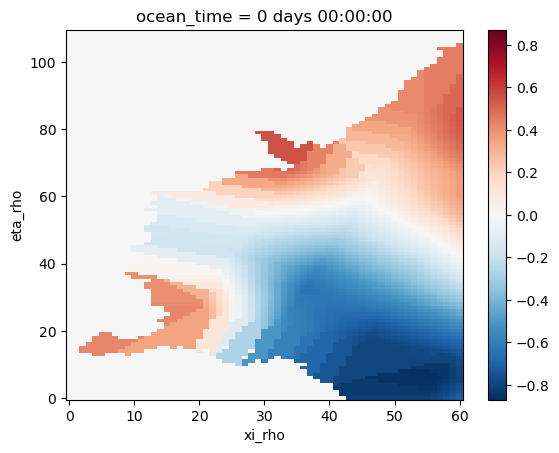

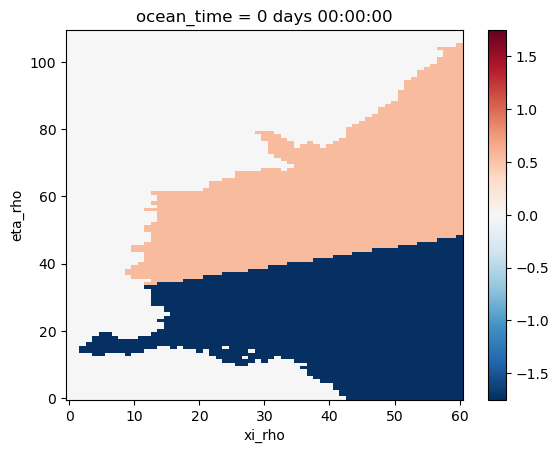

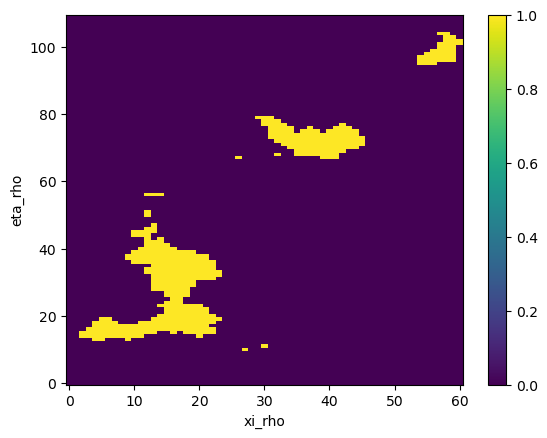

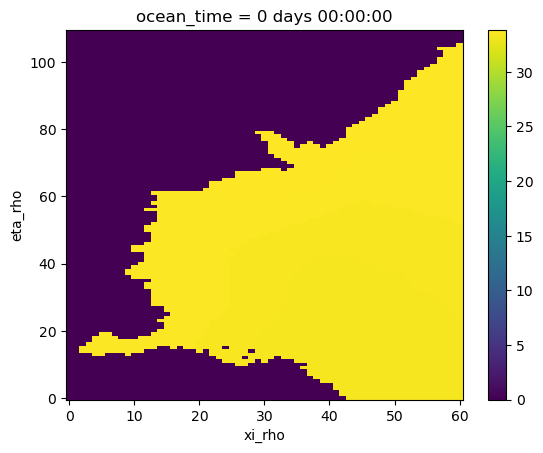

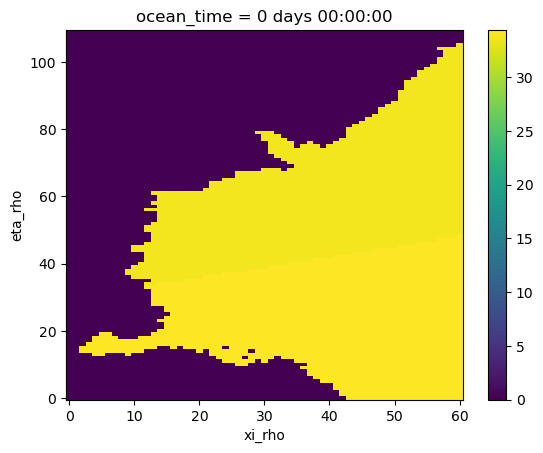

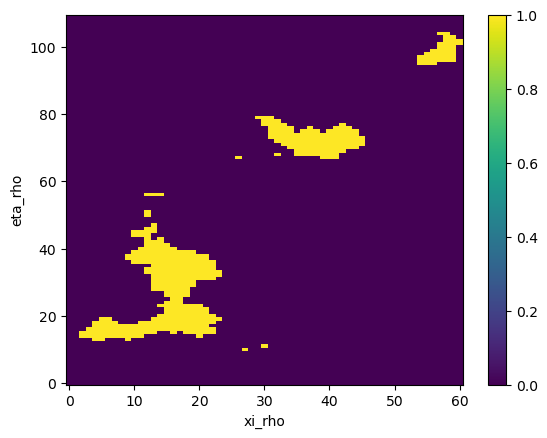

-3.035171584846764
0.880542449620151
33.37281076154792
34.63127905481598


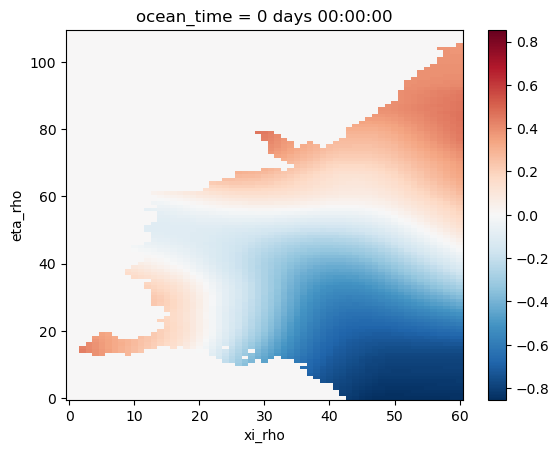

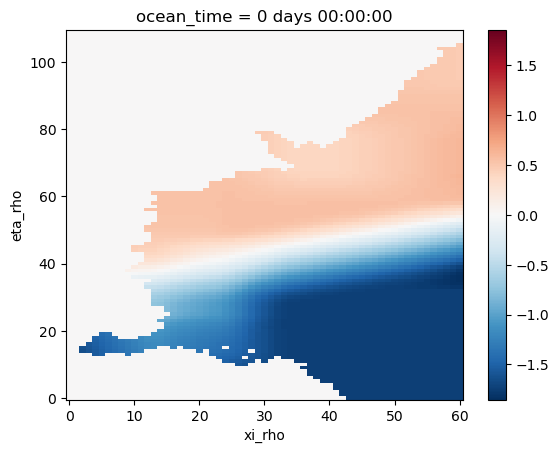

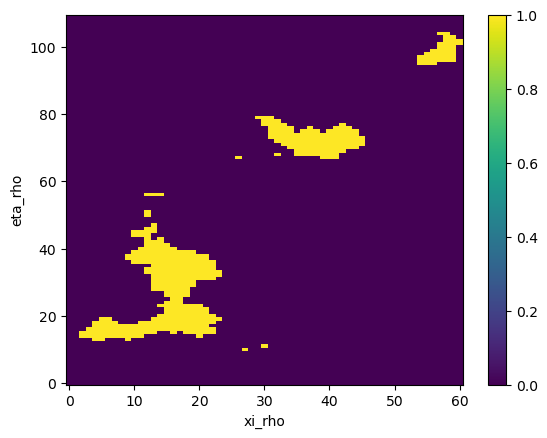

In [26]:
## test masking all sub-ice cells, and re-introduce constant ICs here
out = xr.open_dataset(out_file)
out

grd = xr.open_dataset(grd_file)
grd

print('NOTE - PYTHON IS WAITING FOR THE USER INPUT!')

(out.temp.isel(s_rho=-1)*grd.mask_rho).plot()
plt.show()
(out.temp.isel(s_rho=0)*grd.mask_rho).plot()
plt.show()
((grd.mask_rho==1) & (grd.zice!=0)).plot()
plt.show()

(out.salt.isel(s_rho=-1)*grd.mask_rho).plot()
plt.show()
(out.salt.isel(s_rho=0)*grd.mask_rho).plot()
plt.show()
((grd.mask_rho==1) & (grd.zice!=0)).plot()
plt.show()


final = out.copy()

postProcessingOptions='fill_and_smooth'

if postProcessingOptions=='fill_ice_shelves':
    final['temp']=(final.temp.where(~((grd.mask_rho==1) & (grd.zice!=0)),0.0))
    final['salt']=(final.salt.where(~((grd.mask_rho==1) & (grd.zice!=0)),34.0))
elif postProcessingOptions=='smooth':
    final['temp'] = final.temp.rolling(eta_rho=10,center=True).mean().rolling(xi_rho=10,center=True).mean().interpolate_na(dim='xi_rho',method='linear',fill_value="extrapolate").interpolate_na(dim='eta_rho',method='linear',fill_value="extrapolate")
    final['salt'] = final.salt.rolling(eta_rho=10,center=True).mean().rolling(xi_rho=10,center=True).mean().interpolate_na(dim='xi_rho',method='linear',fill_value="extrapolate").interpolate_na(dim='eta_rho',method='linear',fill_value="extrapolate")
elif postProcessingOptions=='fill_and_smooth':
    final['temp']=(final.temp.where(~((grd.mask_rho==1) & (grd.zice!=0)),0.0))
    final['salt']=(final.salt.where(~((grd.mask_rho==1) & (grd.zice!=0)),34.0))
    final['temp'] = final.temp.rolling(eta_rho=20,center=True).mean().rolling(xi_rho=20,center=True).mean().interpolate_na(dim='xi_rho',method='linear',fill_value="extrapolate").interpolate_na(dim='eta_rho',method='linear',fill_value="extrapolate")
    final['salt'] = final.salt.rolling(eta_rho=20,center=True).mean().rolling(xi_rho=20,center=True).mean().interpolate_na(dim='xi_rho',method='linear',fill_value="extrapolate").interpolate_na(dim='eta_rho',method='linear',fill_value="extrapolate")

if input('Are you sure you want to overwrite? ("True" or "False")'):
    os.system('cp -p '+out_file+' '+out_file+'.backup')
    os.system('rm '+out_file)
    final.to_netcdf(out_file)

print(final.temp.min(skipna=False).values)
print(final.temp.max(skipna=False).values)
print(final.salt.min(skipna=False).values)
print(final.salt.max(skipna=False).values)

(final.temp.isel(s_rho=-1)*grd.mask_rho).plot()
plt.show()
(final.temp.isel(s_rho=0)*grd.mask_rho).plot()
plt.show()
((grd.mask_rho==1) & (grd.zice!=0)).plot()
plt.show()
